# Learn scRNA-seq analysis

- https://scanpy.readthedocs.io/en/stable/tutorials.html

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', FutureWarning)

In [3]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=75, facecolor='white')

In [4]:
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


Download data set

```bash
%%bash

mkdir data
wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
mkdir write
```

## Load data

In [5]:
if not os.path.exists('write'):
    os.makedirs('write')
results_file = 'write/pbmc3k.h5ad'

In [6]:
adata = sc.read_10x_mtx(
    path = 'data/filtered_gene_bc_matrices/hg19/',
    var_names = 'gene_symbols', # alternative is 'gene_ids'
    cache = True
)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [7]:
adata.var_names_make_unique()

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

- Each row is a gene
- Each column is a cell

## Preprocessing

normalizing counts per cell
    finished (0:00:00)


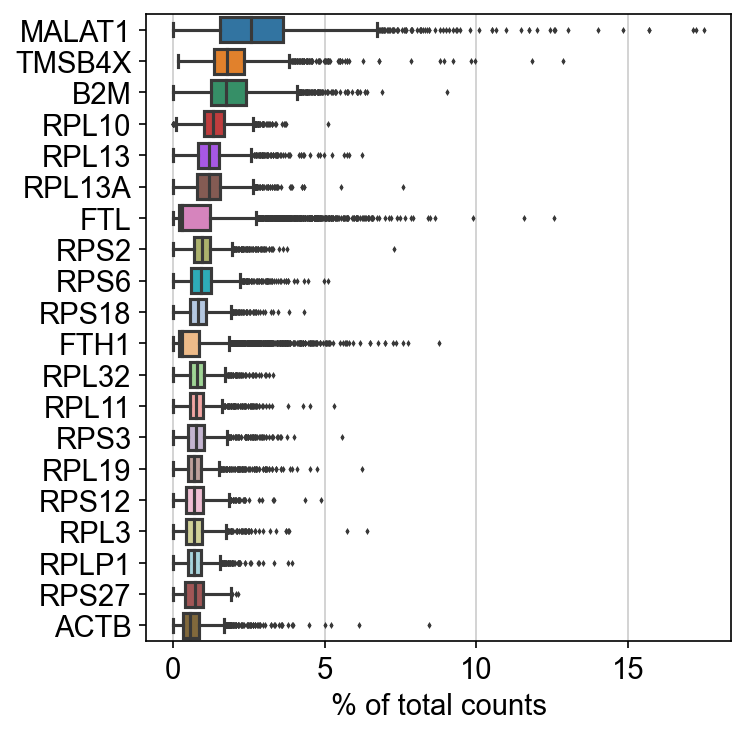

In [9]:
sc.plotting.highest_expr_genes(adata, n_top=20)

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt'], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

In [12]:
adata.var_keys()

['gene_ids',
 'n_cells',
 'mt',
 'n_cells_by_counts',
 'mean_counts',
 'pct_dropout_by_counts',
 'total_counts']

In [13]:
adata.var['n_cells_by_counts'].head(3)

AL627309.1       9
AP006222.2       3
RP11-206L10.2    5
Name: n_cells_by_counts, dtype: int64

In [14]:
adata.obs_keys()

['n_genes',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_mt',
 'pct_counts_mt']

In [15]:
adata.obs['total_counts'].head(3)

AAACATACAACCAC-1    2419.0
AAACATTGAGCTAC-1    4903.0
AAACATTGATCAGC-1    3147.0
Name: total_counts, dtype: float32

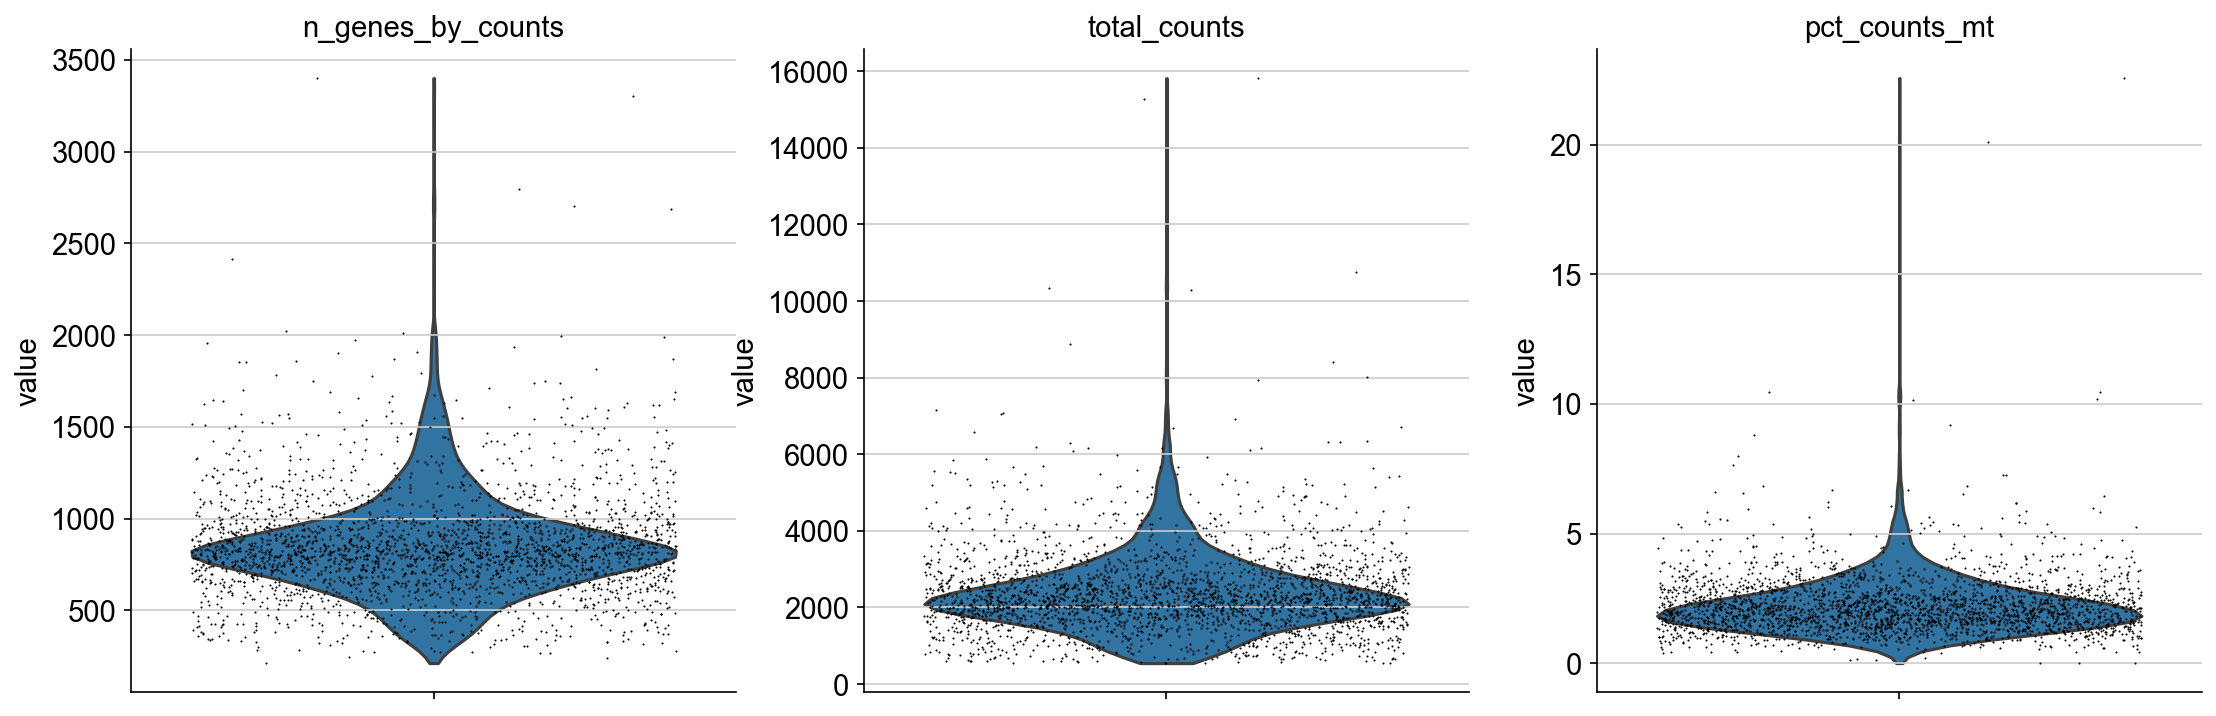

In [16]:
sc.plotting.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=True
)

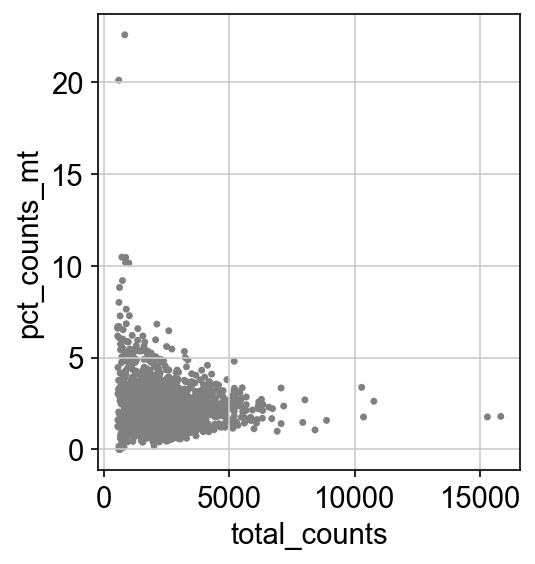

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

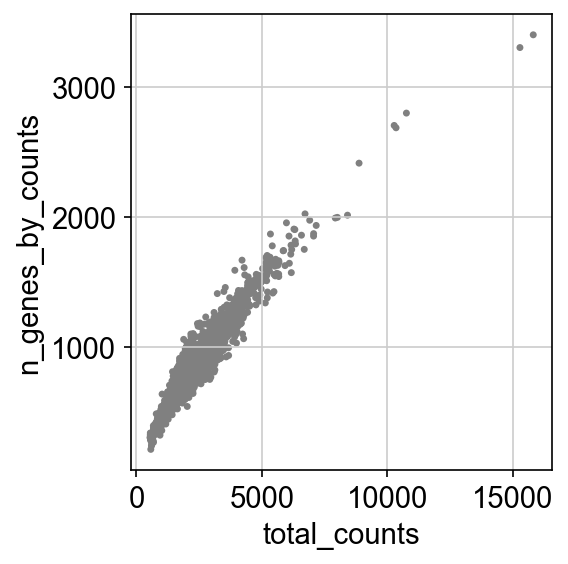

In [18]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Filter

In [19]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

Normalize

In [20]:
sc.pp.normalize_total(adata.copy(), target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [21]:
sc.pp.log1p(adata)

Identify highly-variable genes

In [22]:
sc.pp.highly_variable_genes(
    adata, 
    min_mean=0.125,
    max_mean=3, 
    min_disp=0.5
)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


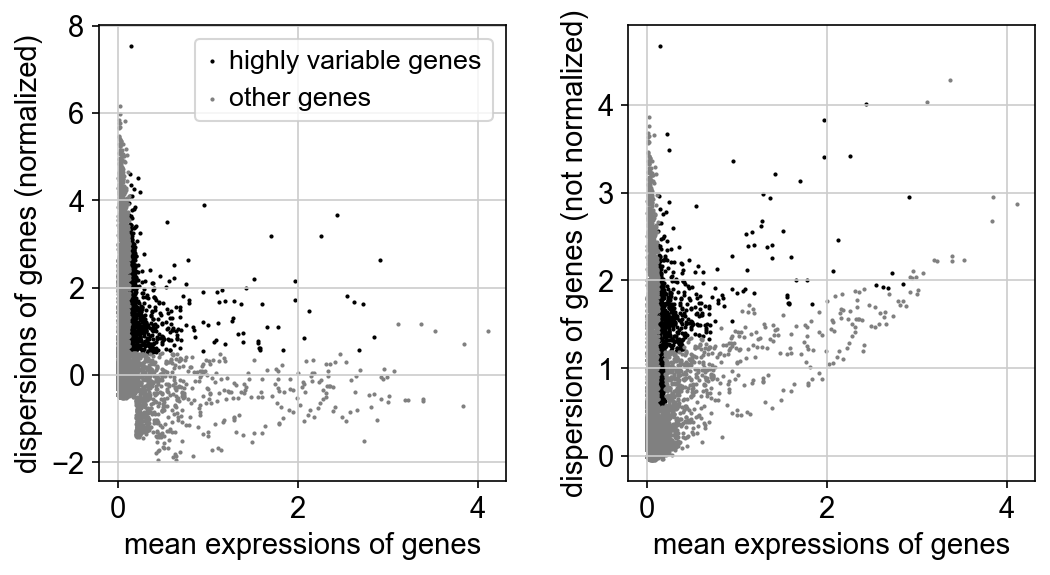

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
adata.raw = adata

Actually do the filtering

In [25]:
adata = adata[:, adata.var.highly_variable]

- Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
- Scale the data to unit variance.

In [26]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:03)


In [27]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

In [28]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


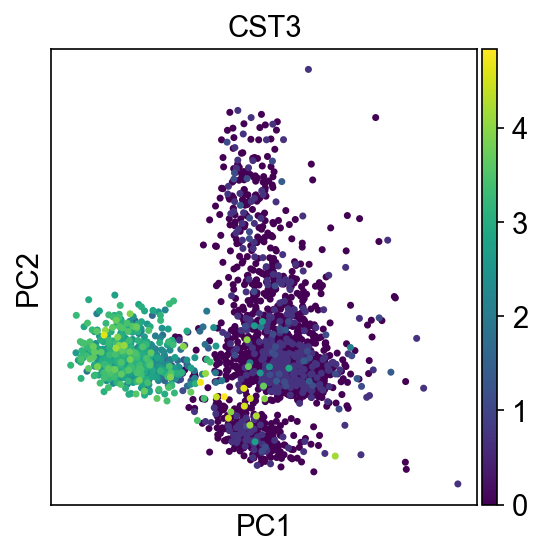

In [29]:
sc.pl.pca(adata, color='CST3')

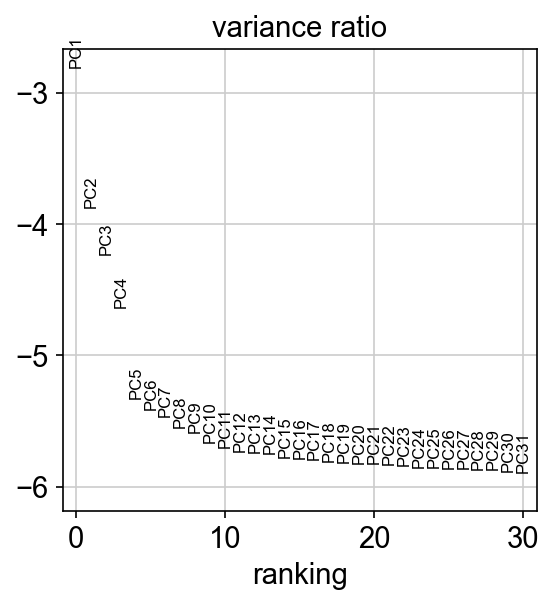

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
adata.write(results_file)

In [32]:
adata

AnnData object with n_obs × n_vars = 2638 × 730
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


Needs the `leidenalg` package to be installed

In [34]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Needs the `louvain` package to be installed

In [35]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


By quantifying the connectivity of partitions (groups, clusters) of the
single-cell graph, partition-based graph abstraction (PAGA) generates a much
simpler abstracted graph (*PAGA graph*) of partitions, in which edge weights
represent confidence in the presence of connections. By tresholding this
confidence in :func:`~scanpy.pl.paga`, a much simpler representation of the
manifold data is obtained, which is nonetheless faithful to the topology of
the manifold.


In [36]:
sc.tl.paga(adata)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


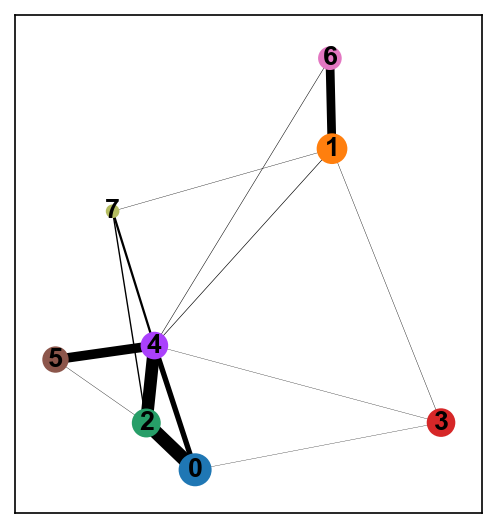

In [37]:
sc.pl.paga(adata)

In [38]:
sc.tl.umap(adata, init_pos='paga')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


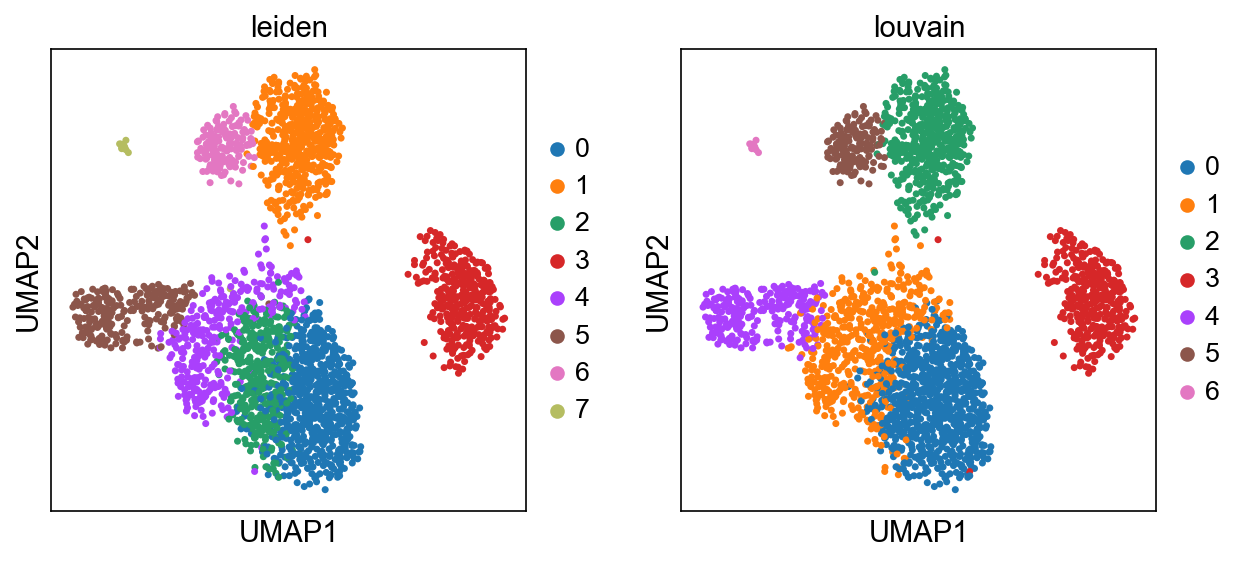

In [39]:
sc.pl.umap(adata, color=['leiden', 'louvain'])

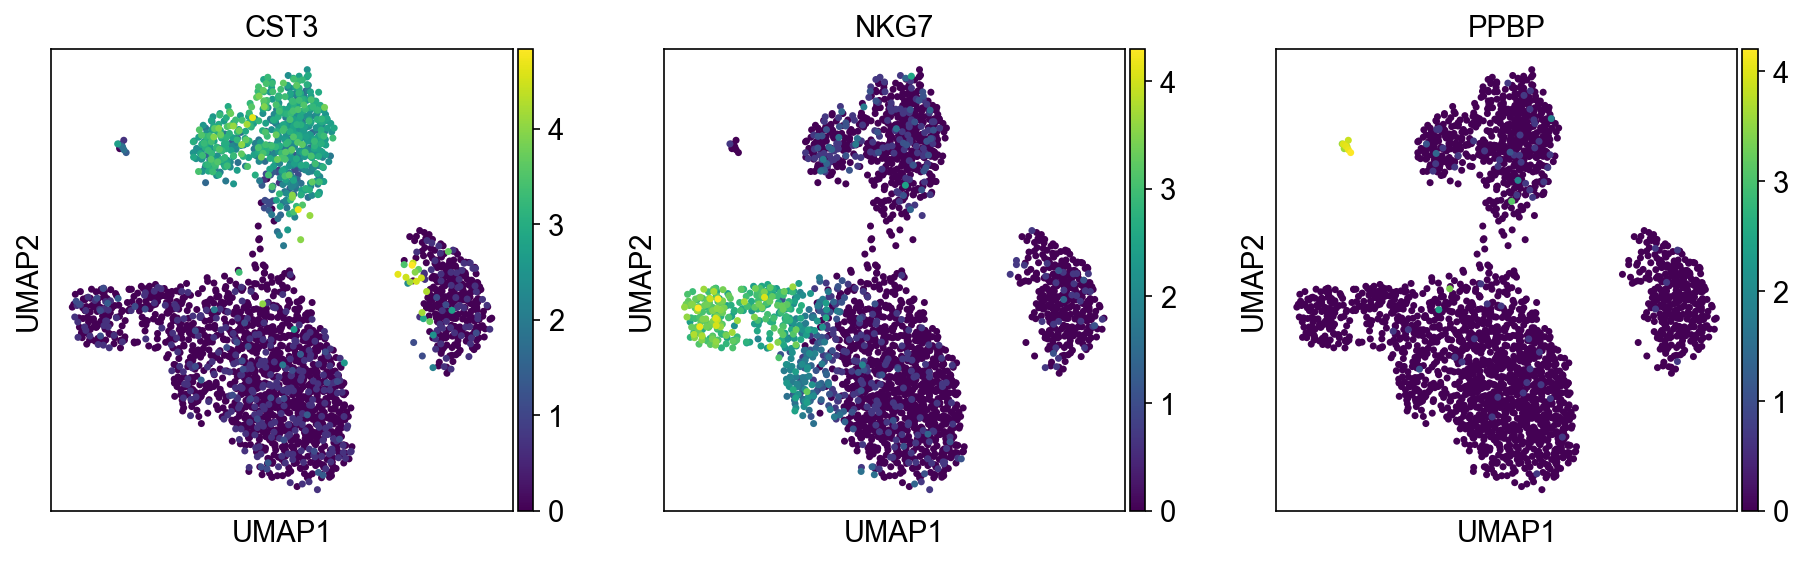

In [40]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

In [41]:
adata.write(results_file)

## Finding marker genes

Detailed tuorial in https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html

Raw scores for cluster 0

In [42]:
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon'
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


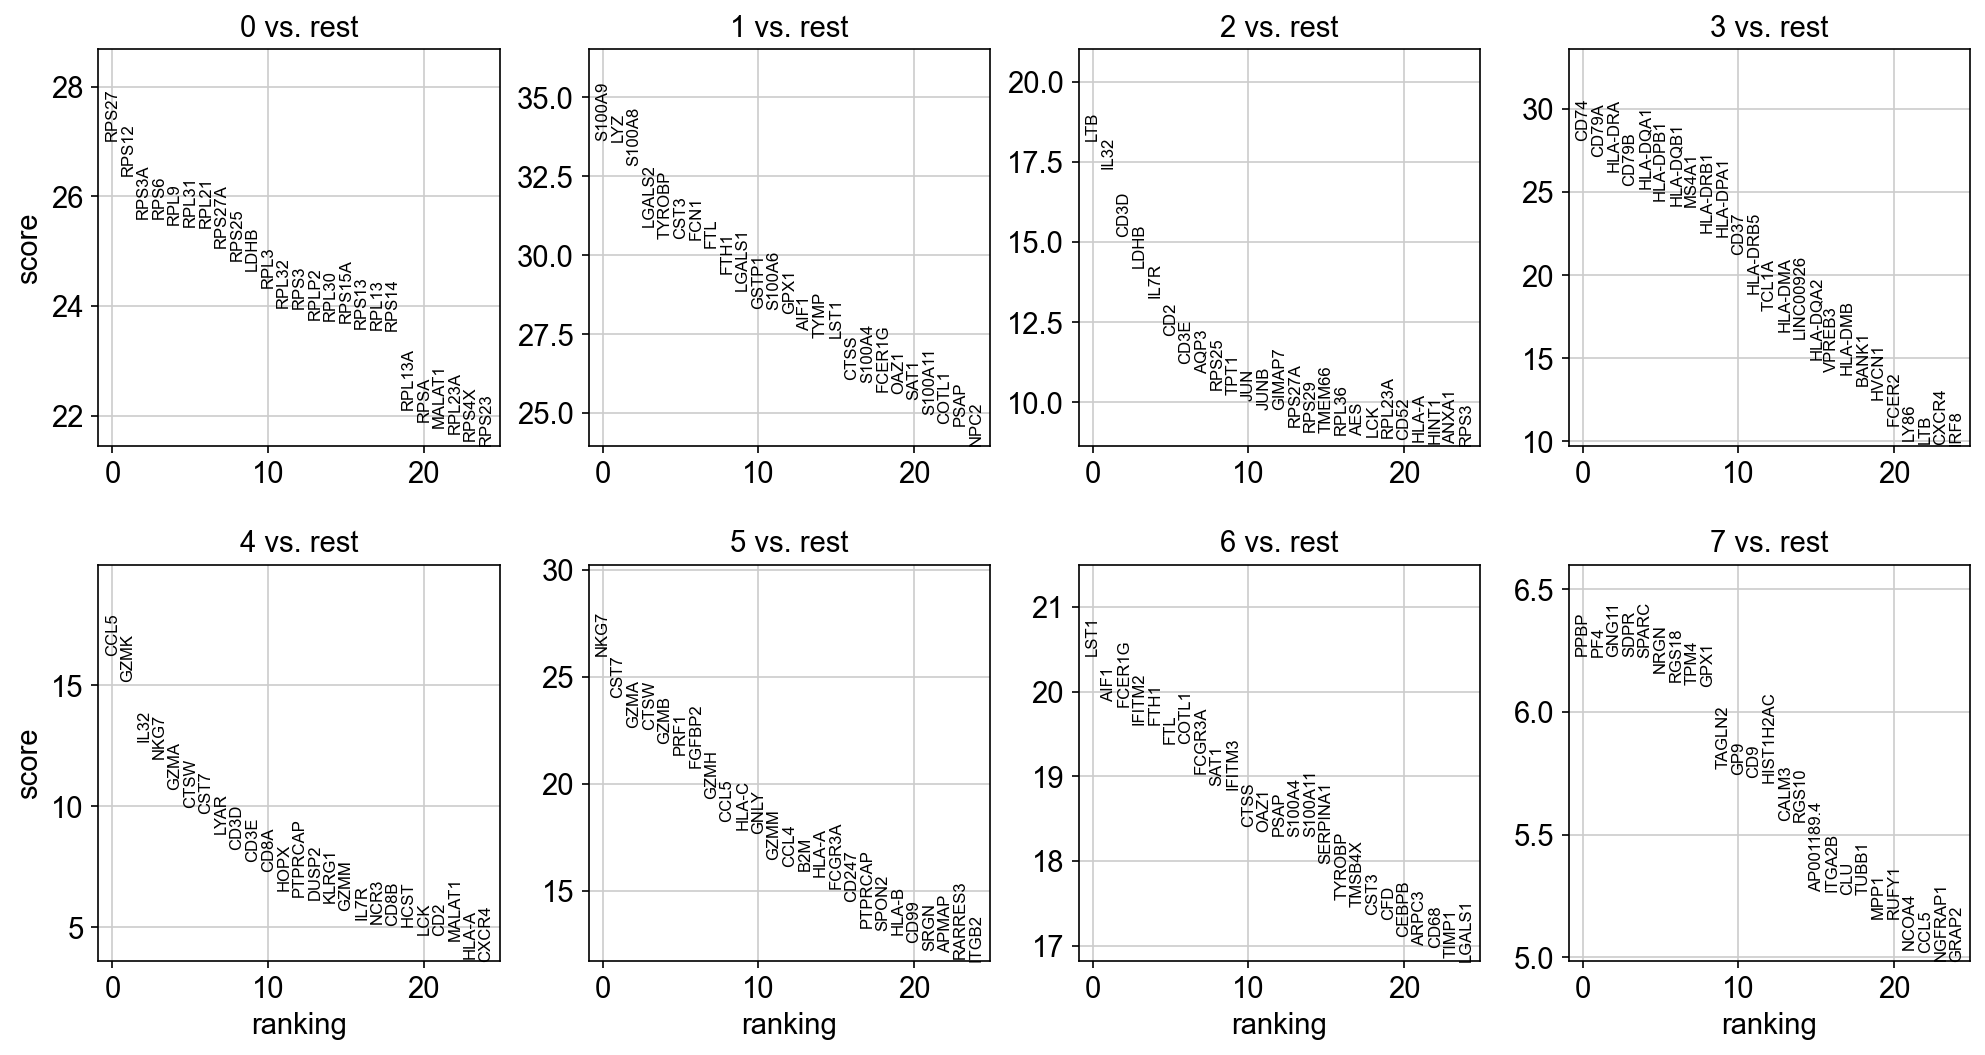

In [43]:
sc.pl.rank_genes_groups(
    adata,
    n_genes=25,
    sharey=False
)

In [44]:
adata.write(results_file)

Define marker genes for later use

In [45]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [46]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS27,S100A9,LTB,CD74,CCL5,NKG7,LST1,PPBP
1,RPS12,LYZ,IL32,CD79A,GZMK,CST7,AIF1,PF4
2,RPS3A,S100A8,CD3D,HLA-DRA,IL32,GZMA,FCER1G,GNG11
3,RPS6,LGALS2,LDHB,CD79B,NKG7,CTSW,IFITM2,SDPR
4,RPL9,TYROBP,IL7R,HLA-DQA1,GZMA,GZMB,FTH1,SPARC


In [47]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS27,1.002523e-160,S100A9,5.819815e-248,LTB,1.057153e-73,CD74,1.100722e-173,CCL5,4.299476e-59,NKG7,9.837169e-149,LST1,1.147290e-92,PPBP,4.711897e-10
1,RPS12,2.726185e-153,LYZ,1.338010e-247,IL32,6.537488e-67,CD79A,2.884592e-162,GZMK,6.854760e-52,CST7,2.128385e-127,AIF1,5.959619e-88,PF4,4.722886e-10
2,RPS3A,1.501491e-144,S100A8,1.186903e-236,CD3D,5.621516e-52,HLA-DRA,2.393445e-151,IL32,1.006749e-36,GZMA,3.031516e-113,FCER1G,1.923334e-87,GNG11,4.722886e-10
3,RPS6,1.846992e-144,LGALS2,1.232857e-209,LDHB,8.285749e-46,CD79B,6.065927e-142,NKG7,5.580158e-33,CTSW,1.872822e-112,IFITM2,1.318503e-85,SDPR,4.772646e-10
4,RPL9,2.810428e-143,TYROBP,9.580929e-205,IL7R,3.792357e-40,HLA-DQA1,4.805249e-140,GZMA,1.227663e-26,GZMB,2.655600e-106,FTH1,1.394607e-85,SPARC,4.965288e-10


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


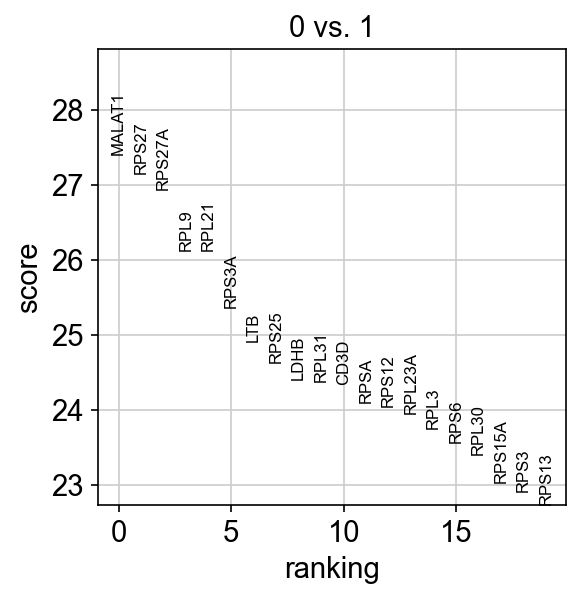

In [48]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

Comparing against reference

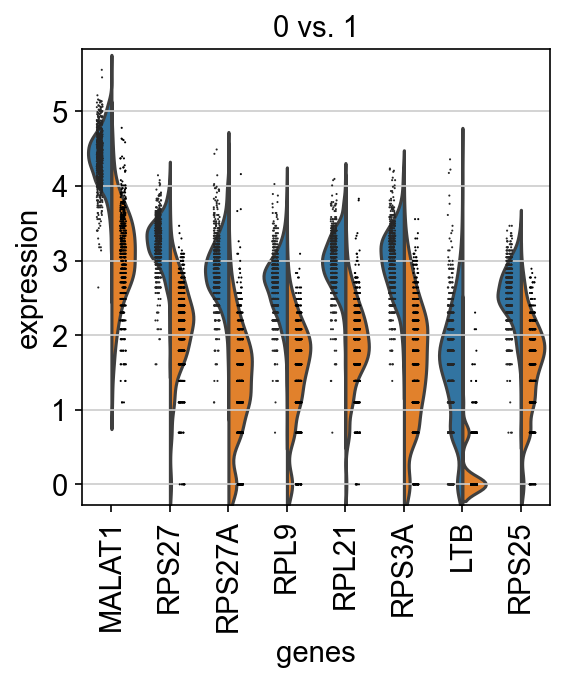

In [49]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Comparing against rest

In [50]:
adata = sc.read(results_file)

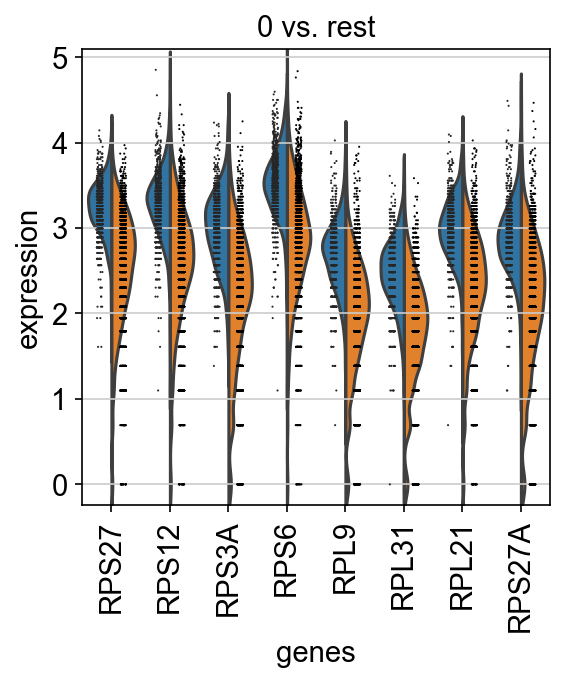

In [51]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Comparing genes across groups

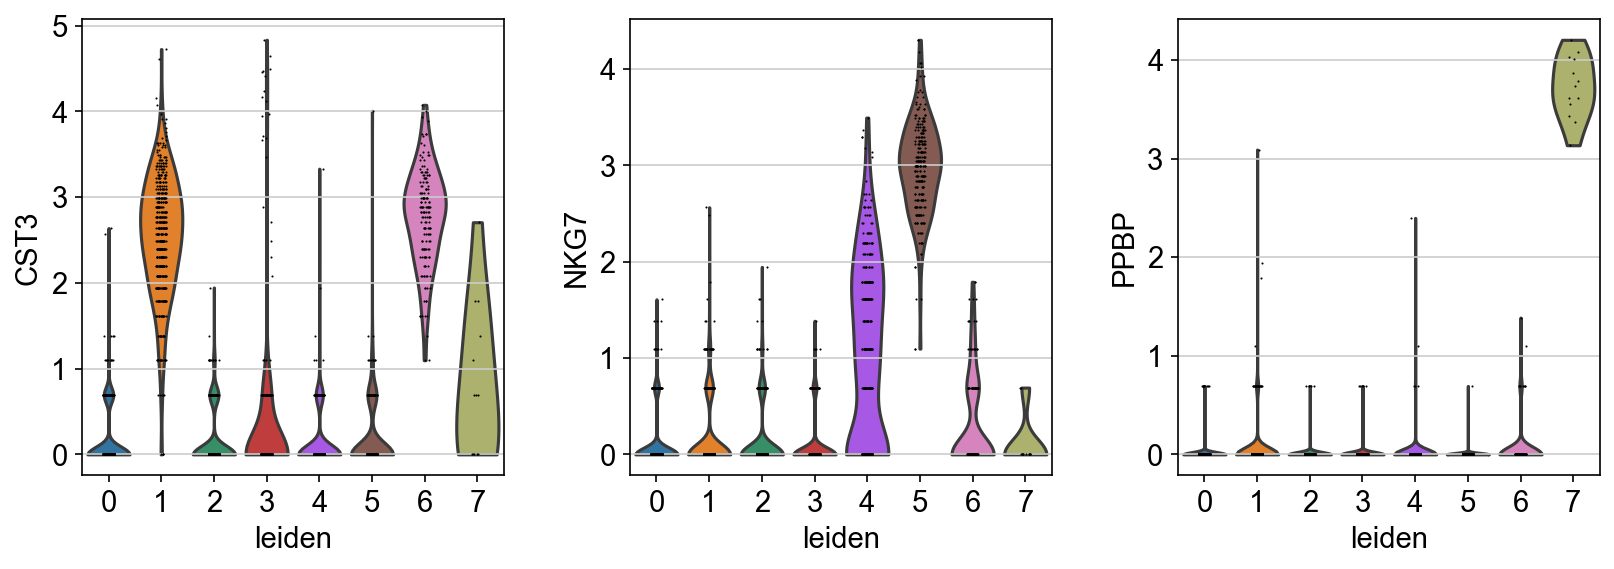

In [52]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Mark cell types manually

In [53]:
new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B', 
    'CD8 T',
    'NK', 
    'FCGR3A Monocytes',
    'Dendritic',
    'Megakaryocytes'
]
adata.rename_categories('leiden', new_cluster_names)

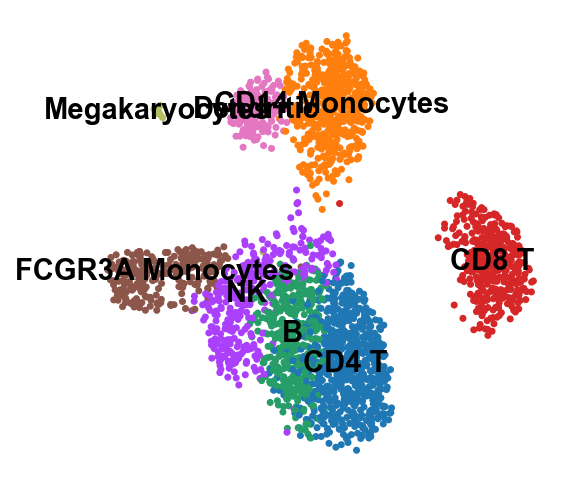

In [54]:
sc.pl.umap(adata, 
           color='leiden', 
           legend_loc='on data', 
           title='', 
           frameon=False, 
           save='.pdf')

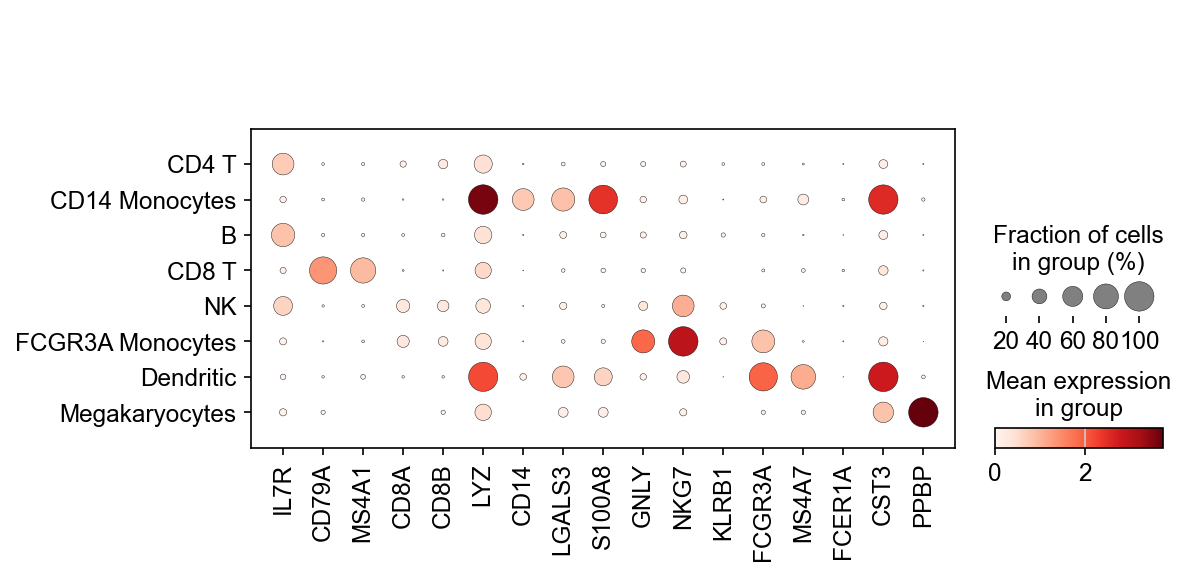

In [55]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

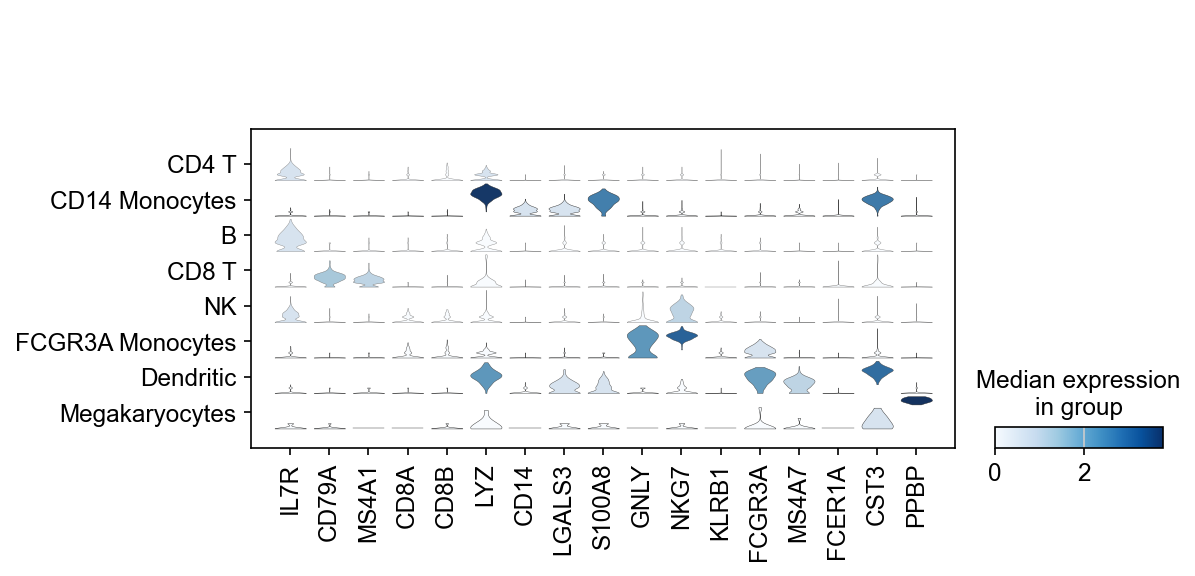

In [56]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

In [57]:
adata

AnnData object with n_obs × n_vars = 2638 × 730
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'louvain'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'louvain', 'louvain_colors', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [58]:
adata.write(results_file, compression='gzip')